# Package

In [1]:
import datetime
import gc
import os

import matplotlib.colors
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd

# Calculate Raw Monsoon Index

In [ ]:
data = nc.Dataset("/work/b08209033/DATA/ERA5/u/u_850_alltime.nc")
u = data["u"][:, -1, :, :]
lon = data["lon"][:]
lat = data["lat"][:]
lons, lats = np.meshgrid(lon, lat)

south_zonal_wind = np.mean(
    u[:, (lat > 5) & (lat < 15), :][:, :, (lon > 40) & (lon < 80)], axis=(1, 2)
)
north_zonal_wind = np.mean(
    u[:, (lat > 20) & (lat < 30), :][:, :, (lon > 70) & (lon < 90)], axis=(1, 2)
)
zonal_wind_shear = south_zonal_wind - north_zonal_wind

del u
del data
del south_zonal_wind
del north_zonal_wind
_ = gc.collect()

# Calculate running-averaged Monsoon Index

In [3]:
def estimate_running_length(array, length):
    smoothed = np.convolve(array, np.ones(length) / length, mode="same")
    index = np.argmax(smoothed.reshape(-1, 365) > 0, axis=1)
    return smoothed, index, index.mean(), index.std(), index.min(), index.max()


MOVING_LEN = 28
monsoon_index, onset_date, _, _, _, _ = estimate_running_length(
    zonal_wind_shear, MOVING_LEN
)
monsoon_index_grad = np.gradient(monsoon_index)
monsoon_index = monsoon_index.reshape(-1, 365)
monsoon_index_grad = monsoon_index_grad.reshape(-1, 365)

# for i in range(14,35):
#     _, mean, std, minval, maxval = estimate_running_length(zonal_wind_shear, i)
#     print(f"Length: {i}, Mean: {mean:4.3f}, Std: {std:4.3f}, Min: {minval:4.3f}, Max: {maxval:4.3f}")

# Calculate Low Pressure Occurrence

In [4]:
df = pd.read_csv(
    "/home/b08209033/IndianMonsoon/TempestDetect/TropicalCycloneCount_925.csv",
    sep="\t",
    on_bad_lines="skip",
    header=None,
)
df.columns = ["Year", "Month", "Day", "Occurrence", "Time"]
df = df.astype(int)
occurrence = df[df.columns[3]].to_numpy()
occurrence_smooth = np.convolve(
    occurrence, np.ones(MOVING_LEN) / MOVING_LEN, mode="same"
)
occurrence_smooth = occurrence_smooth.reshape(43, -1)

In [5]:
from statistics import mean

Text(0.5, 0.98, 'Upper right and Lower right\nR = 0.92856')

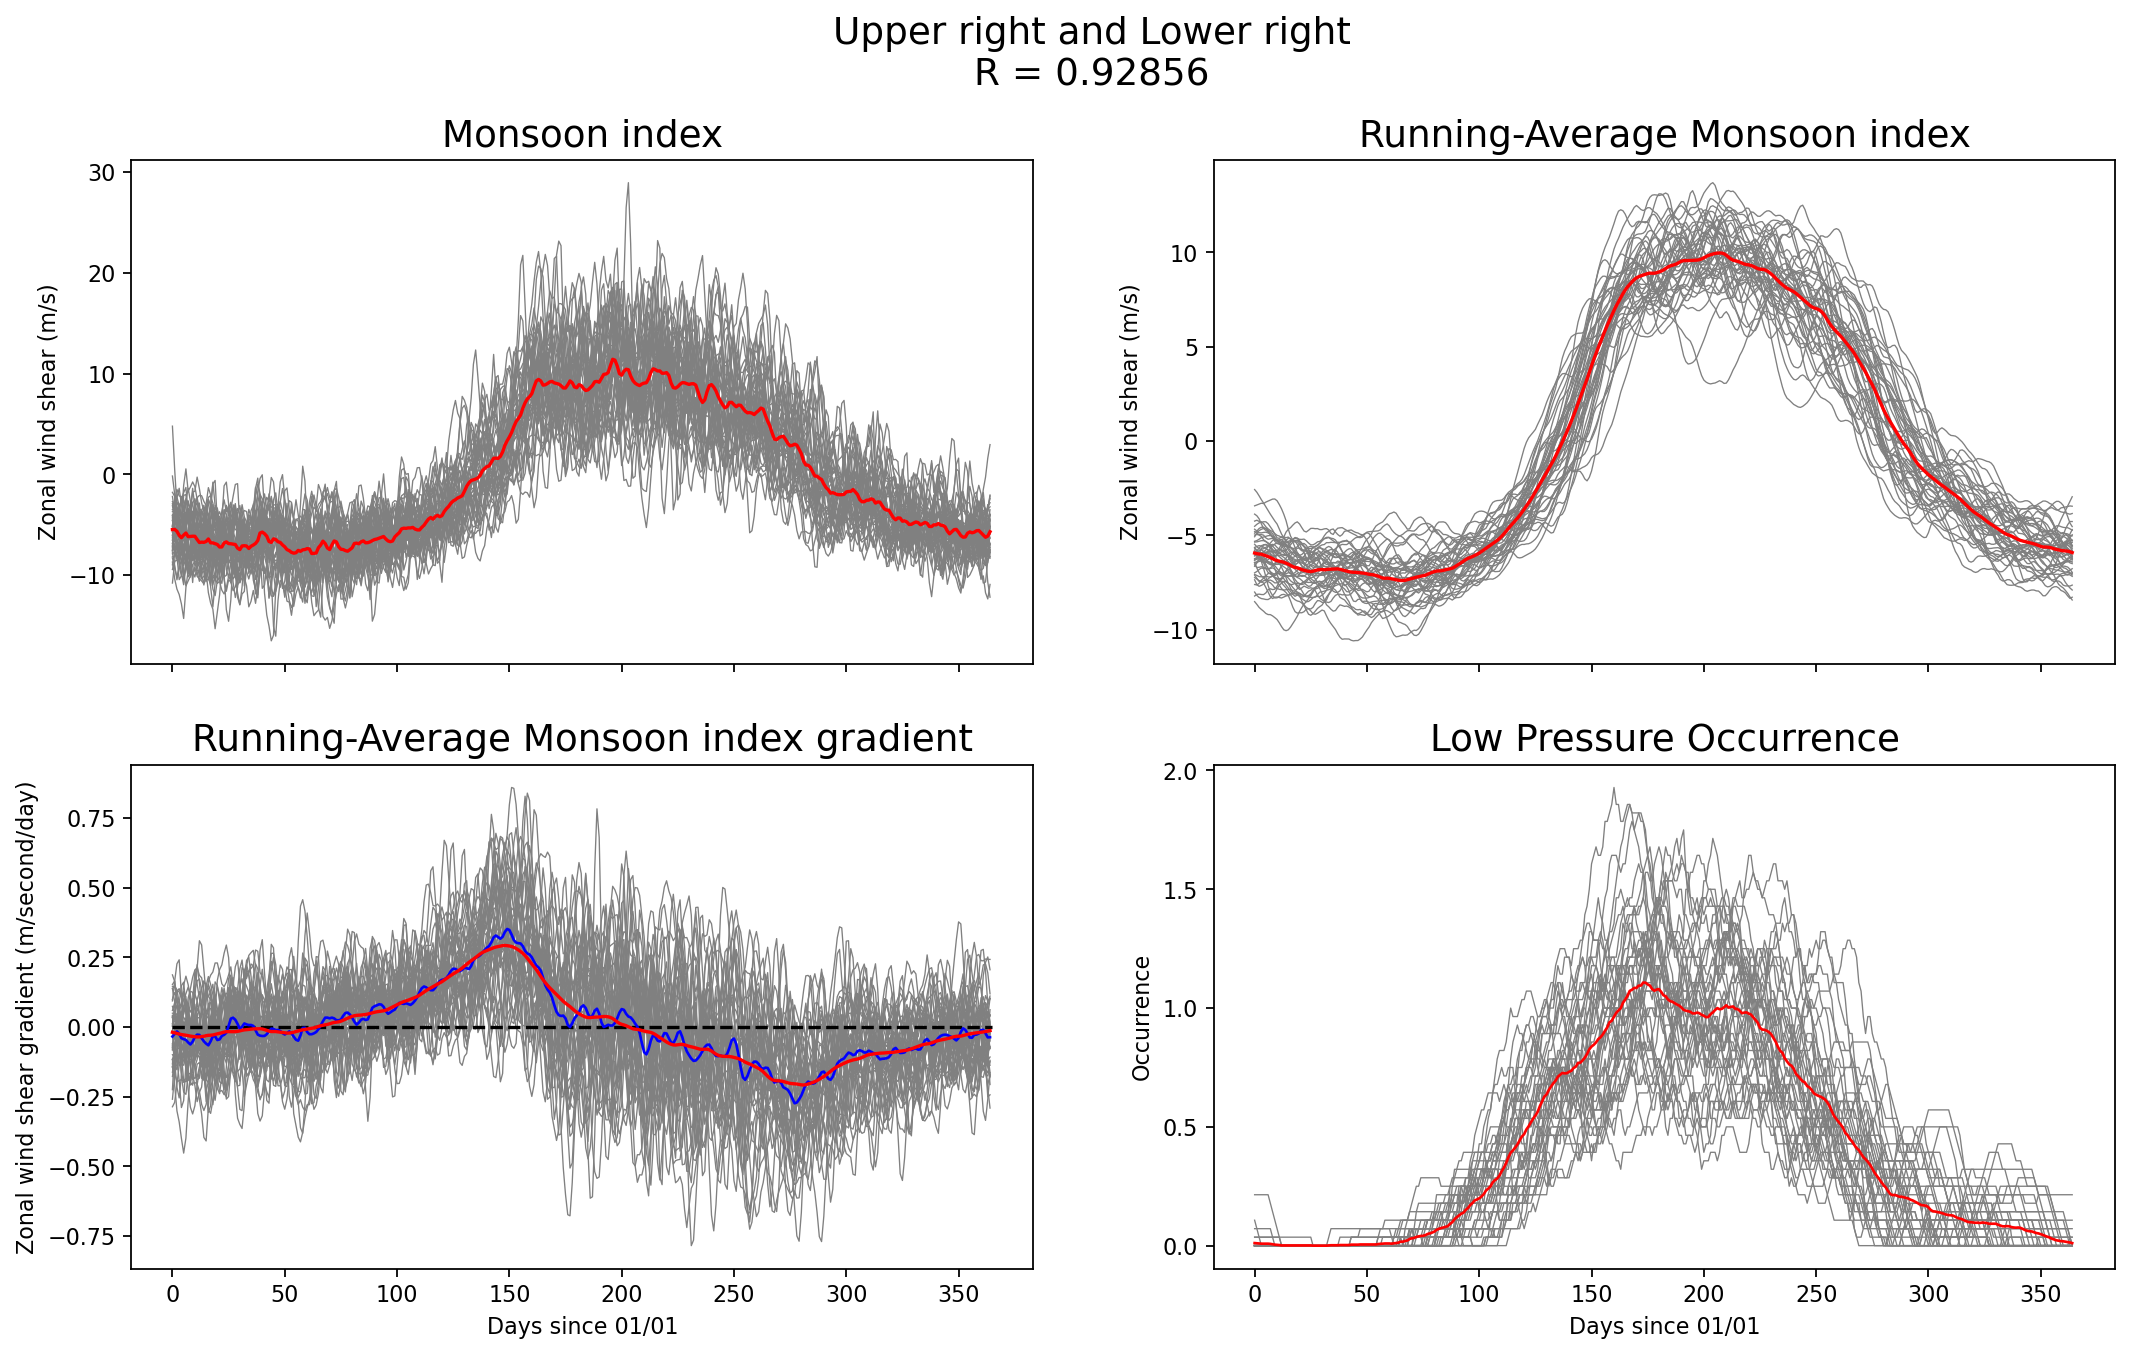

In [6]:
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(
        16, 9), dpi=160, sharex=True)
plt.rcParams.update({"font.size": 14})
for i in range(43):
    axes[0, 0].plot(zonal_wind_shear.reshape(-1, 365)[i], color="gray", lw=0.6)
axes[0, 0].plot(
    np.mean(zonal_wind_shear.reshape(-1, 365), axis=0), color="red")
axes[0, 0].set_ylabel("Zonal wind shear (m/s)")
axes[0, 0].set_title("Monsoon index")

for i in range(43):
    axes[0, 1].plot(monsoon_index[i], color="gray", lw=0.6)
axes[0, 1].plot(np.mean(monsoon_index, axis=0), color="red")
axes[0, 1].set_ylabel("Zonal wind shear (m/s)")
axes[0, 1].set_title("Running-Average Monsoon index")

for i in range(43):
    axes[1, 0].plot(monsoon_index_grad[i], color="gray", lw=0.6)
axes[1, 0].plot([0, 365], [0, 0], "k--")
axes[1, 0].plot(np.mean(monsoon_index_grad, axis=0), color="b", lw=1.2)
axes[1, 0].plot(
    np.convolve(
        np.mean(monsoon_index_grad, axis=0),
        np.ones(MOVING_LEN) / MOVING_LEN,
        mode="same",
    ),
    color="red",
    lw=1.5,
)
axes[1, 0].set_xlabel("Days since 01/01")
axes[1, 0].set_ylabel("Zonal wind shear gradient (m/second/day)")
axes[1, 0].set_title("Running-Average Monsoon index gradient")

for i in range(43):
    axes[1, 1].plot(occurrence_smooth[i], color="gray", lw=0.6)
axes[1, 1].plot(np.mean(occurrence_smooth, axis=0), color="r", lw=1.2)
axes[1, 1].set_xlabel("Days since 01/01")
axes[1, 1].set_ylabel("Occurrence")
axes[1, 1].set_title("Low Pressure Occurrence")
fig.suptitle(
    f"Upper right and Lower right\nR = {
        np.corrcoef(
            np.mean(
                monsoon_index, axis=0), np.mean(
                    occurrence_smooth, axis=0))[
                        0, 1]:4.5f}"
)

In [7]:
def get_streamfunction(filepath, global_map=False):
    # global_data = nc.Dataset("/work/b08209033/DATA/ERA5/Zonalmean_Divergent_UV.nc")
    global_data = nc.Dataset(filepath)
    pressure = global_data["plev"][:]
    lon = global_data["lon"][:]
    lat = global_data["lat"][:]
    lons, lats = np.meshgrid(lon, lat)
    order_z = np.argsort(pressure)
    pressure = pressure[order_z]
    v = global_data["v"][:, order_z, :, :]

    pressure_grad = np.diff(np.insert(pressure, 0, 0))

    mean_v = np.mean(v, axis=-1)
    mean_v = np.insert(mean_v, 0, 0, axis=1)
    mean_v = (mean_v[:, :-1, :] + mean_v[:, 1:, :]) / 2
    if global_map:
        weighting = 2 * np.pi * 6371 * 1e3 * np.cos(np.deg2rad(lat)) / 9.81
    else:
        weighting = (
            np.deg2rad(np.abs(lon[0] - lon[-1]))
            * 6371
            * 1e3
            * np.cos(np.deg2rad(lat))
            / 9.81
        )

    streamfunc = np.cumsum(
        np.swapaxes(
            np.swapaxes(
                mean_v, 1, -1) * pressure_grad, -1, 1) * weighting, axis=1, )
    return streamfunc, lat, pressure

In [8]:
# def get_thetae(t_filepath, q_filepath, ps_filepath, global_map=False):
#     # global_data = nc.Dataset("/work/b08209033/DATA/ERA5/Zonalmean_Divergent_UV.nc")
#     t_data = nc.Dataset(t_filepath)
#     q_data = nc.Dataset(q_filepath)
#     ps_data = nc.Dataset(ps_filepath)
#     pressure = global_data["plev"][:]
#     lon = global_data["lon"][:]
#     lat = global_data["lat"][:]
#     lons, lats = np.meshgrid(lon, lat)
#     order_z = np.argsort(pressure)
#     pressure = pressure[order_z]
#     v = global_data["v"][:, order_z, :, :]

#     pressure_grad = np.diff(np.insert(pressure, 0, 0))

#     mean_v = np.mean(v, axis=-1)
#     mean_v = np.insert(mean_v, 0, 0, axis=1)
#     mean_v = (mean_v[:, :-1, :] + mean_v[:, 1:, :]) / 2
#     if global_map:
#         weighting = 2 * np.pi * 6371 * 1e3 * np.cos(np.deg2rad(lat)) / 9.81
#     else:
#         weighting = (
#             np.deg2rad(np.abs(lon[0] - lon[-1]))
#             * 6371
#             * 1e3
#             * np.cos(np.deg2rad(lat))
#             / 9.81
#         )

#     streamfunc = np.cumsum(
#         np.swapaxes(
#             np.swapaxes(
#                 mean_v, 1, -1) * pressure_grad, -1, 1) * weighting, axis=1, )
#     return streamfunc, lat, pressure

In [9]:
day_in_year_index = []
for i in range(12):
    day_in_year_index.append(
        (datetime.date(2001, i + 1, 1) - datetime.date(2001, 1, 1)).days
    )
print(day_in_year_index)

[0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]


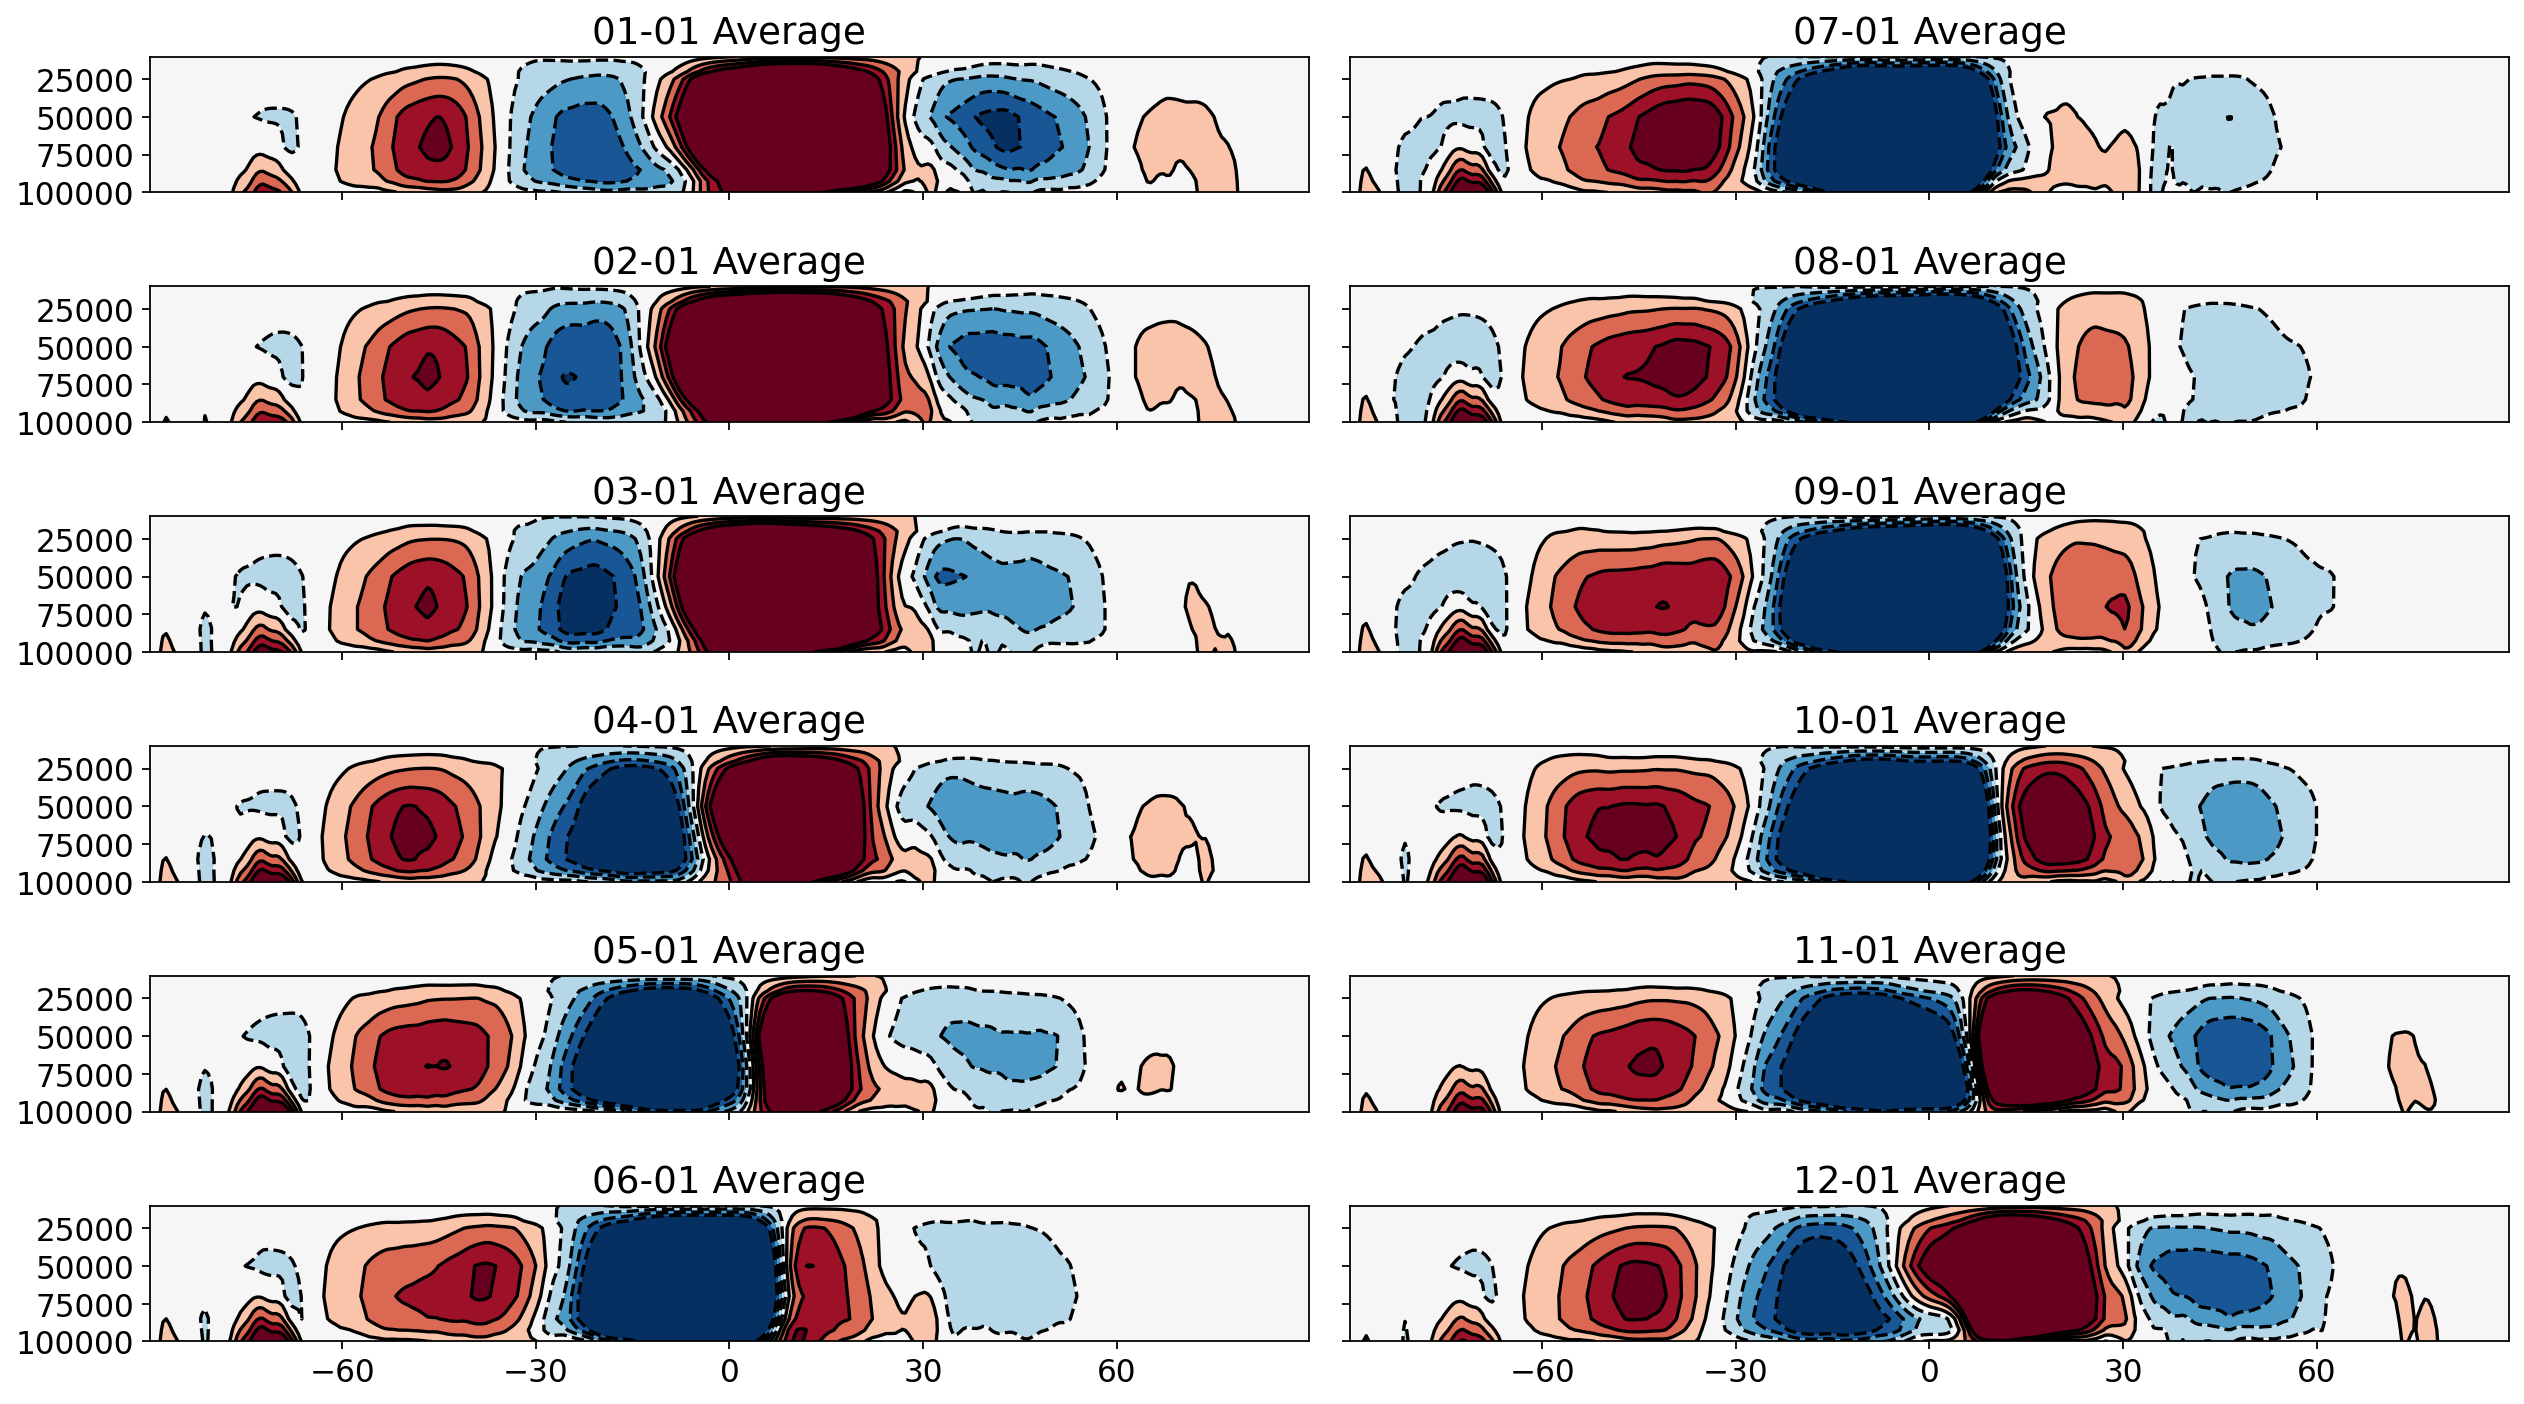

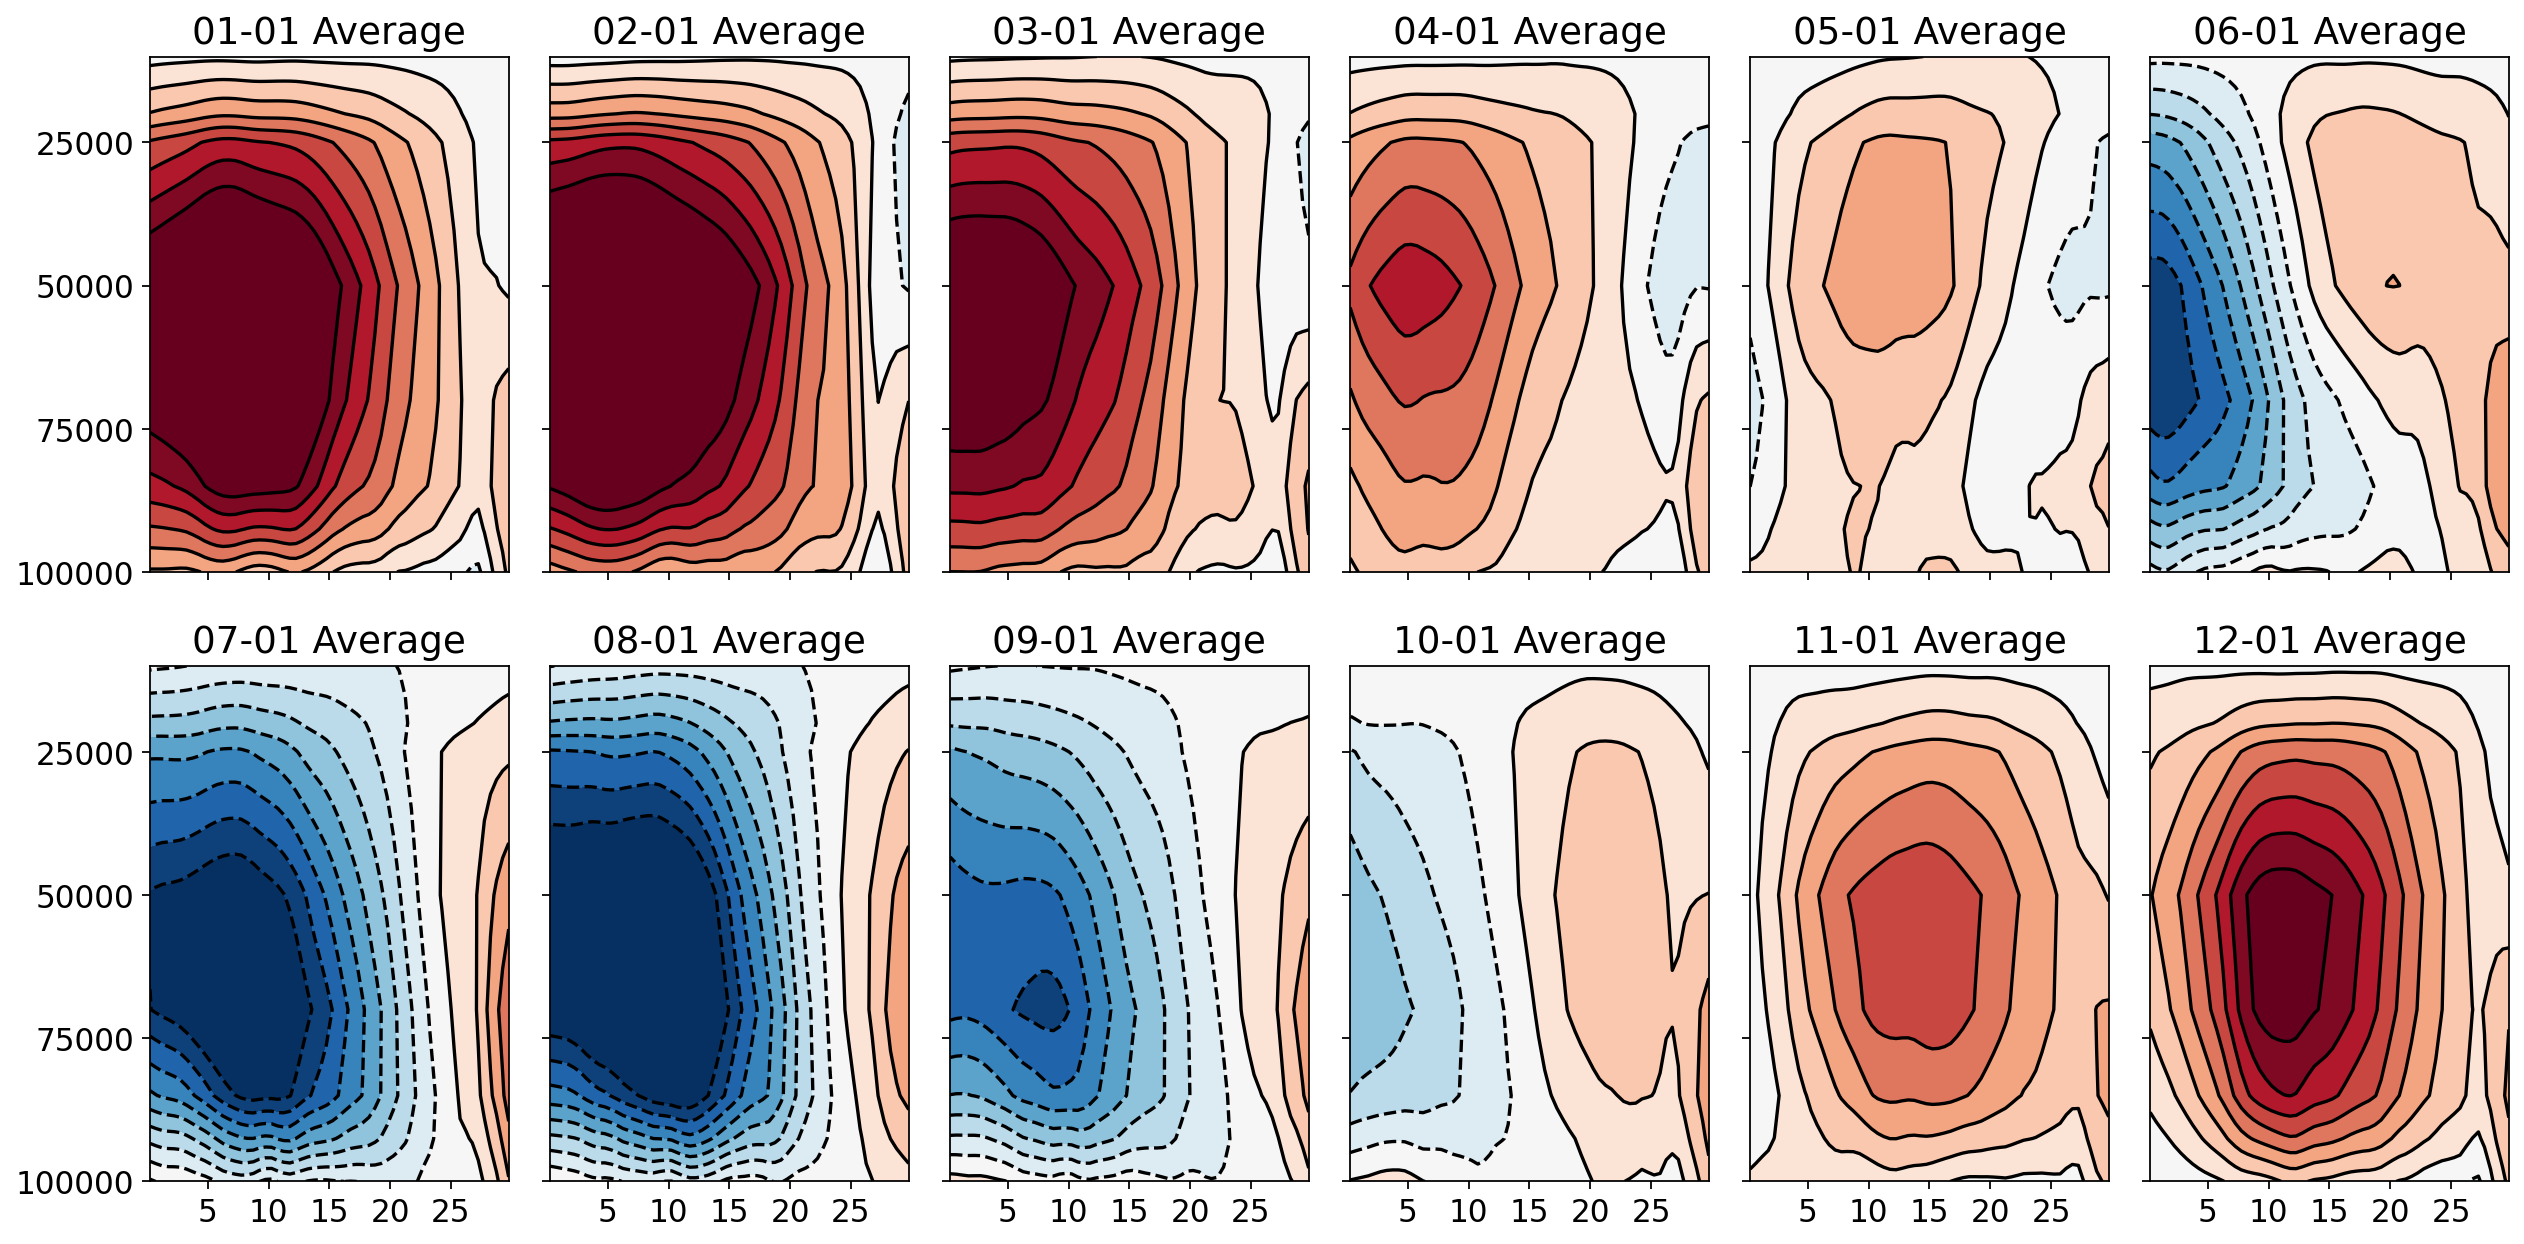

In [10]:
Display_Global_Dataset = True
Display_Regional_Dataset = True


if Display_Global_Dataset:
    sf, lat, pressure = get_streamfunction(
        "/work/b08209033/DATA/ERA5/Zonalmean_Divergent_UV.nc", global_map=True
    )
    fig, axes = plt.subplots(
        nrows=6, ncols=2, figsize=(16, 9), dpi=160, sharex=True, sharey=True
    )

    axes[0, 0].invert_yaxis()
    axes[0, 0].set_xticks(np.linspace(-90, 90, 7))
    axes[0, 0].set_yticks(np.linspace(25000, 100000, 4))
    for (i, j), ax in np.ndenumerate(axes):
        tmp = np.mean(sf[day_in_year_index[6 * j + i]:: 365], axis=0)
        ax.contourf(
            lat,
            pressure,
            tmp,
            levels=np.linspace(-5e10, 5e10, 8),
            extend="both",
            cmap="RdBu_r",
        )
        ax.contour(lat, pressure, tmp,
                   levels=np.linspace(-5e10, 5e10, 8), colors="k")
        ax.set_title(f"{6*j+i+1:02}-01 Average")
    plt.tight_layout()
if Display_Regional_Dataset:
    sf, lat, pressure = get_streamfunction(
        "/work/b08209033/DATA/ERA5/Indian_Divergent_UV.nc", global_map=False
    )
    fig, axes = plt.subplots(
        nrows=2, ncols=6, figsize=(16, 8), dpi=160, sharex=True, sharey=True
    )

    axes[0, 0].invert_yaxis()
    axes[0, 0].set_xticks(np.linspace(0, 30, 7))
    axes[0, 0].set_yticks(np.linspace(25000, 100000, 4))
    for (i, j), ax in np.ndenumerate(axes):
        tmp = np.mean(sf[day_in_year_index[6 * i + j]:: 365], axis=0)
        ax.contourf(
            lat,
            pressure,
            tmp,
            levels=np.linspace(-4e10, 4e10, 16),
            extend="both",
            cmap="RdBu_r",
        )
        ax.contour(lat, pressure, tmp,
                   levels=np.linspace(-4e10, 4e10, 16), colors="k")
        ax.set_title(f"{6*i+j+1:02}-01 Average")
    plt.tight_layout()

(43, 365, 8, 60)
[122 126 127 127 128 130 131 131 132 133 133 134 134 134 135 135 135 135
 137 137 137 137 138 139 139 140 140 141 141 142 142 143 143 144 145 145
 146 147 147 148 150 153 156]


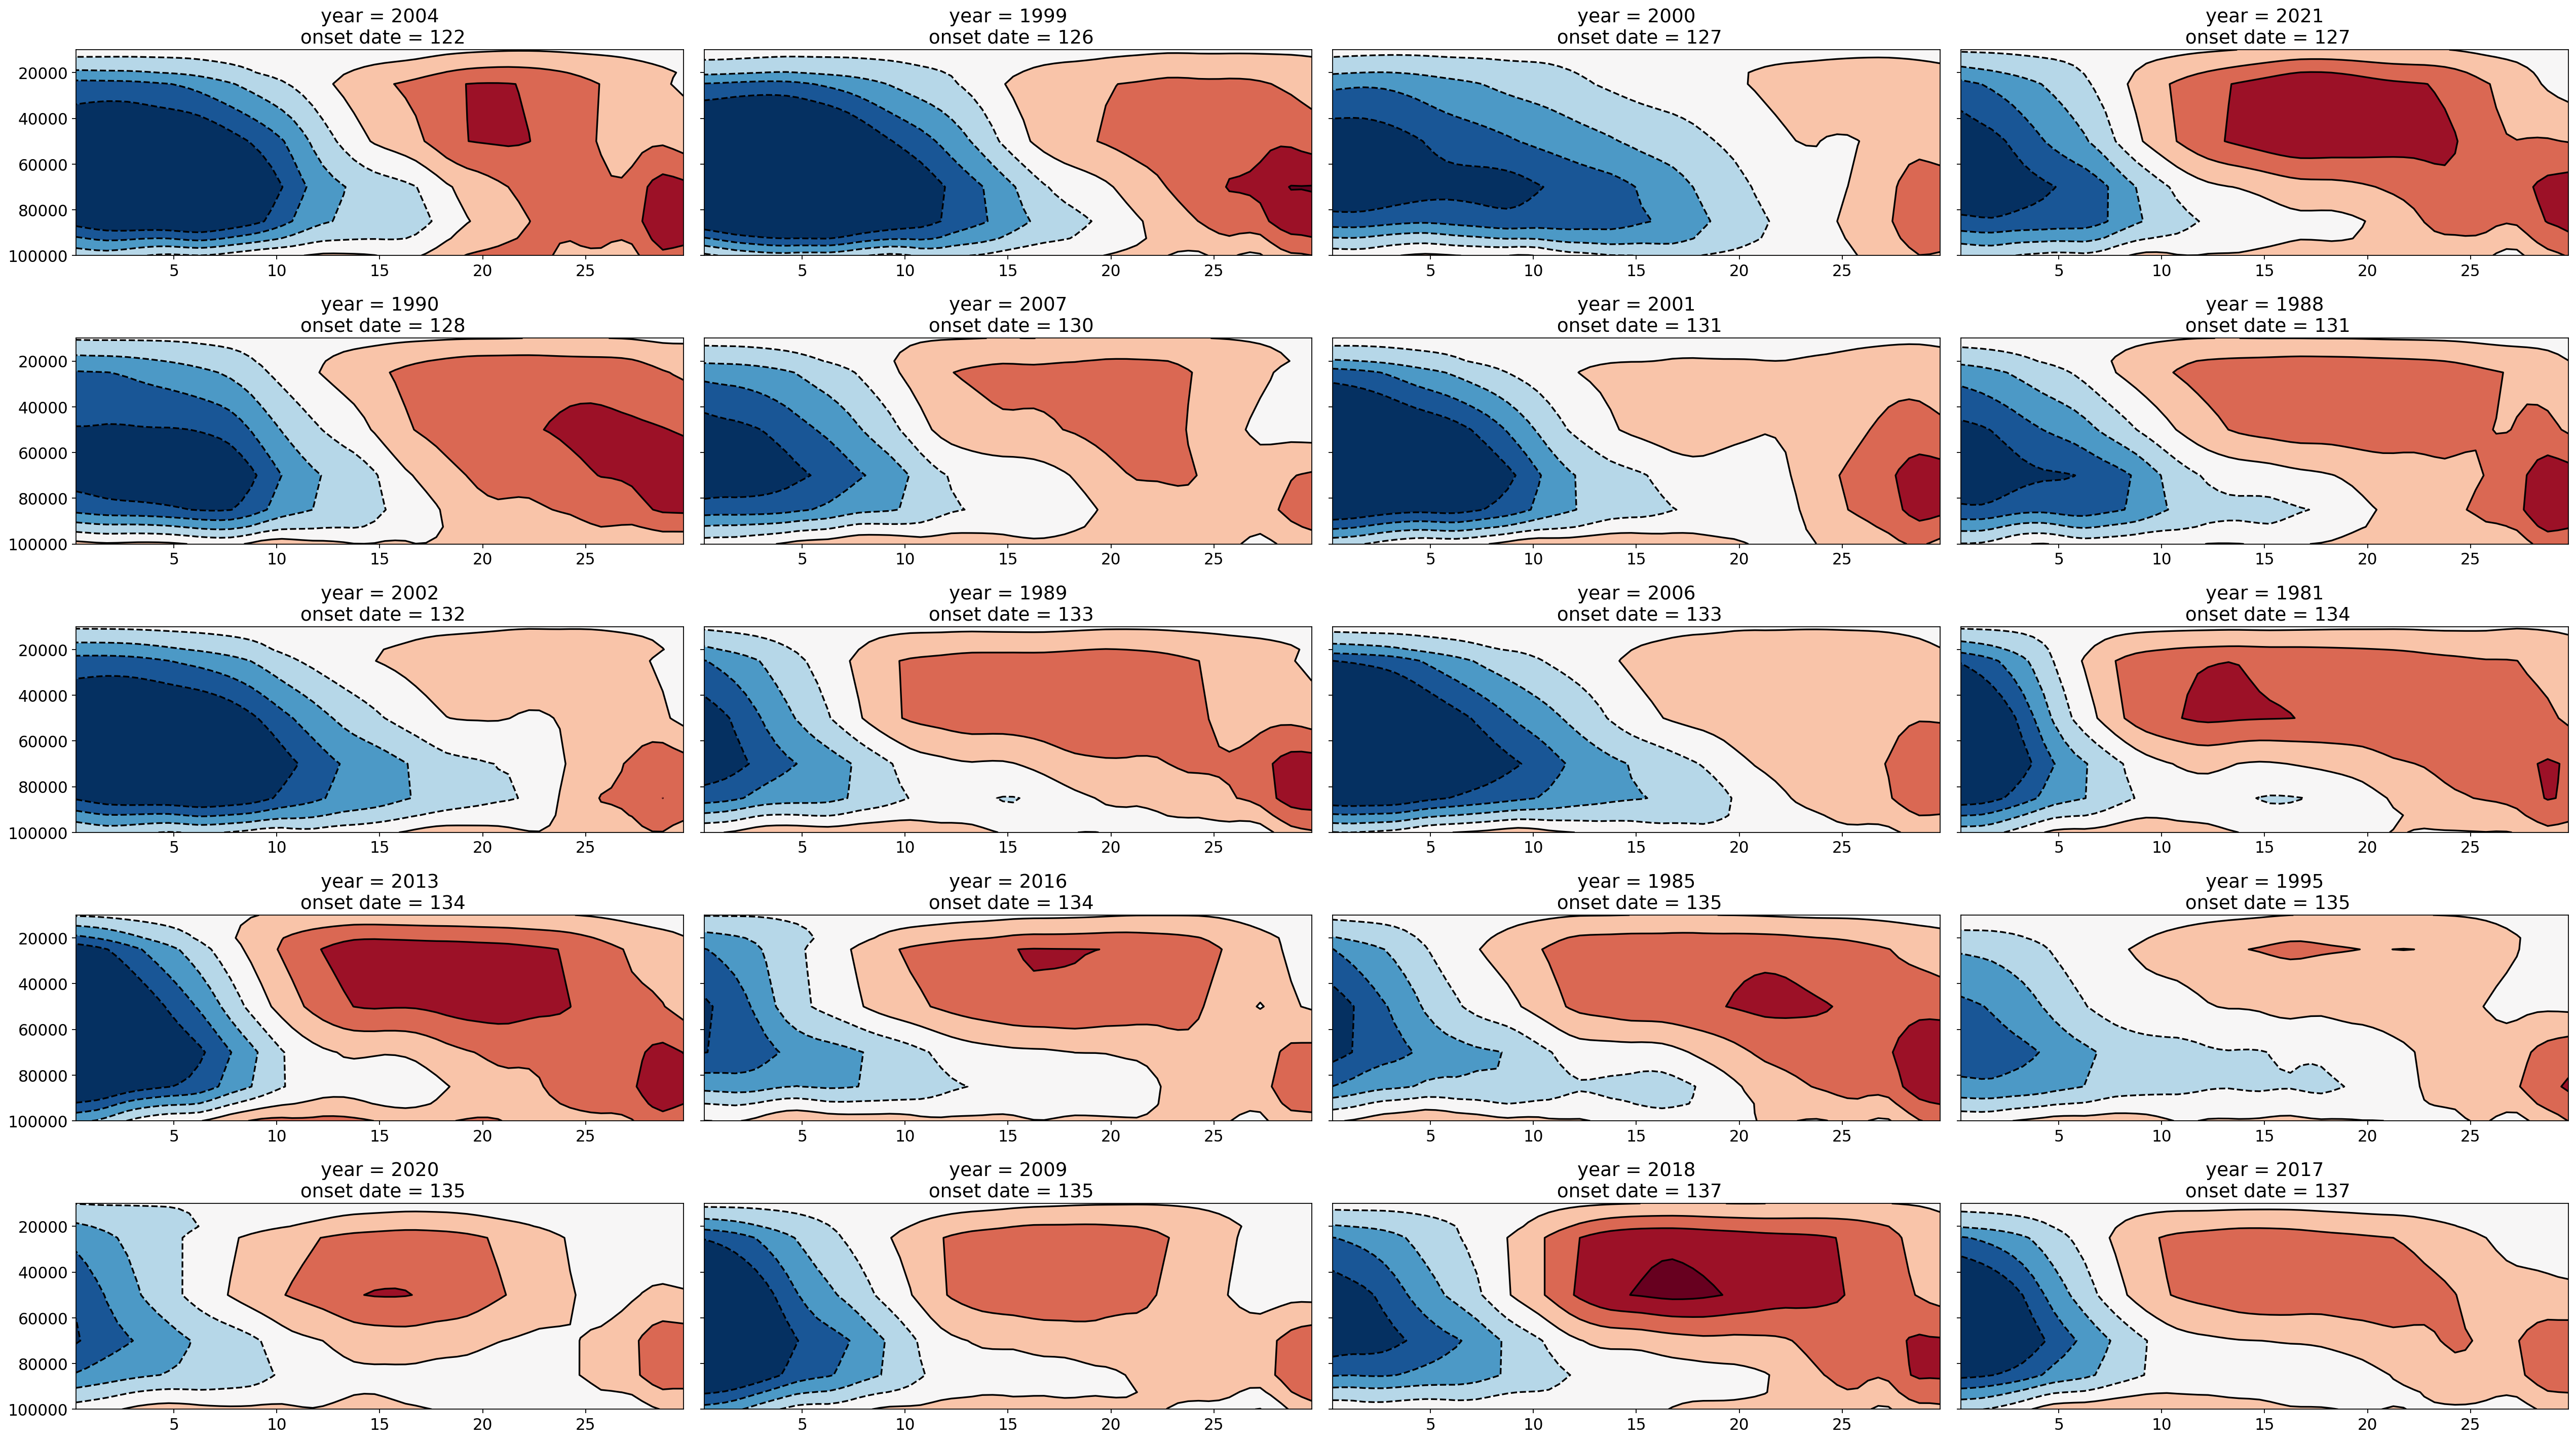

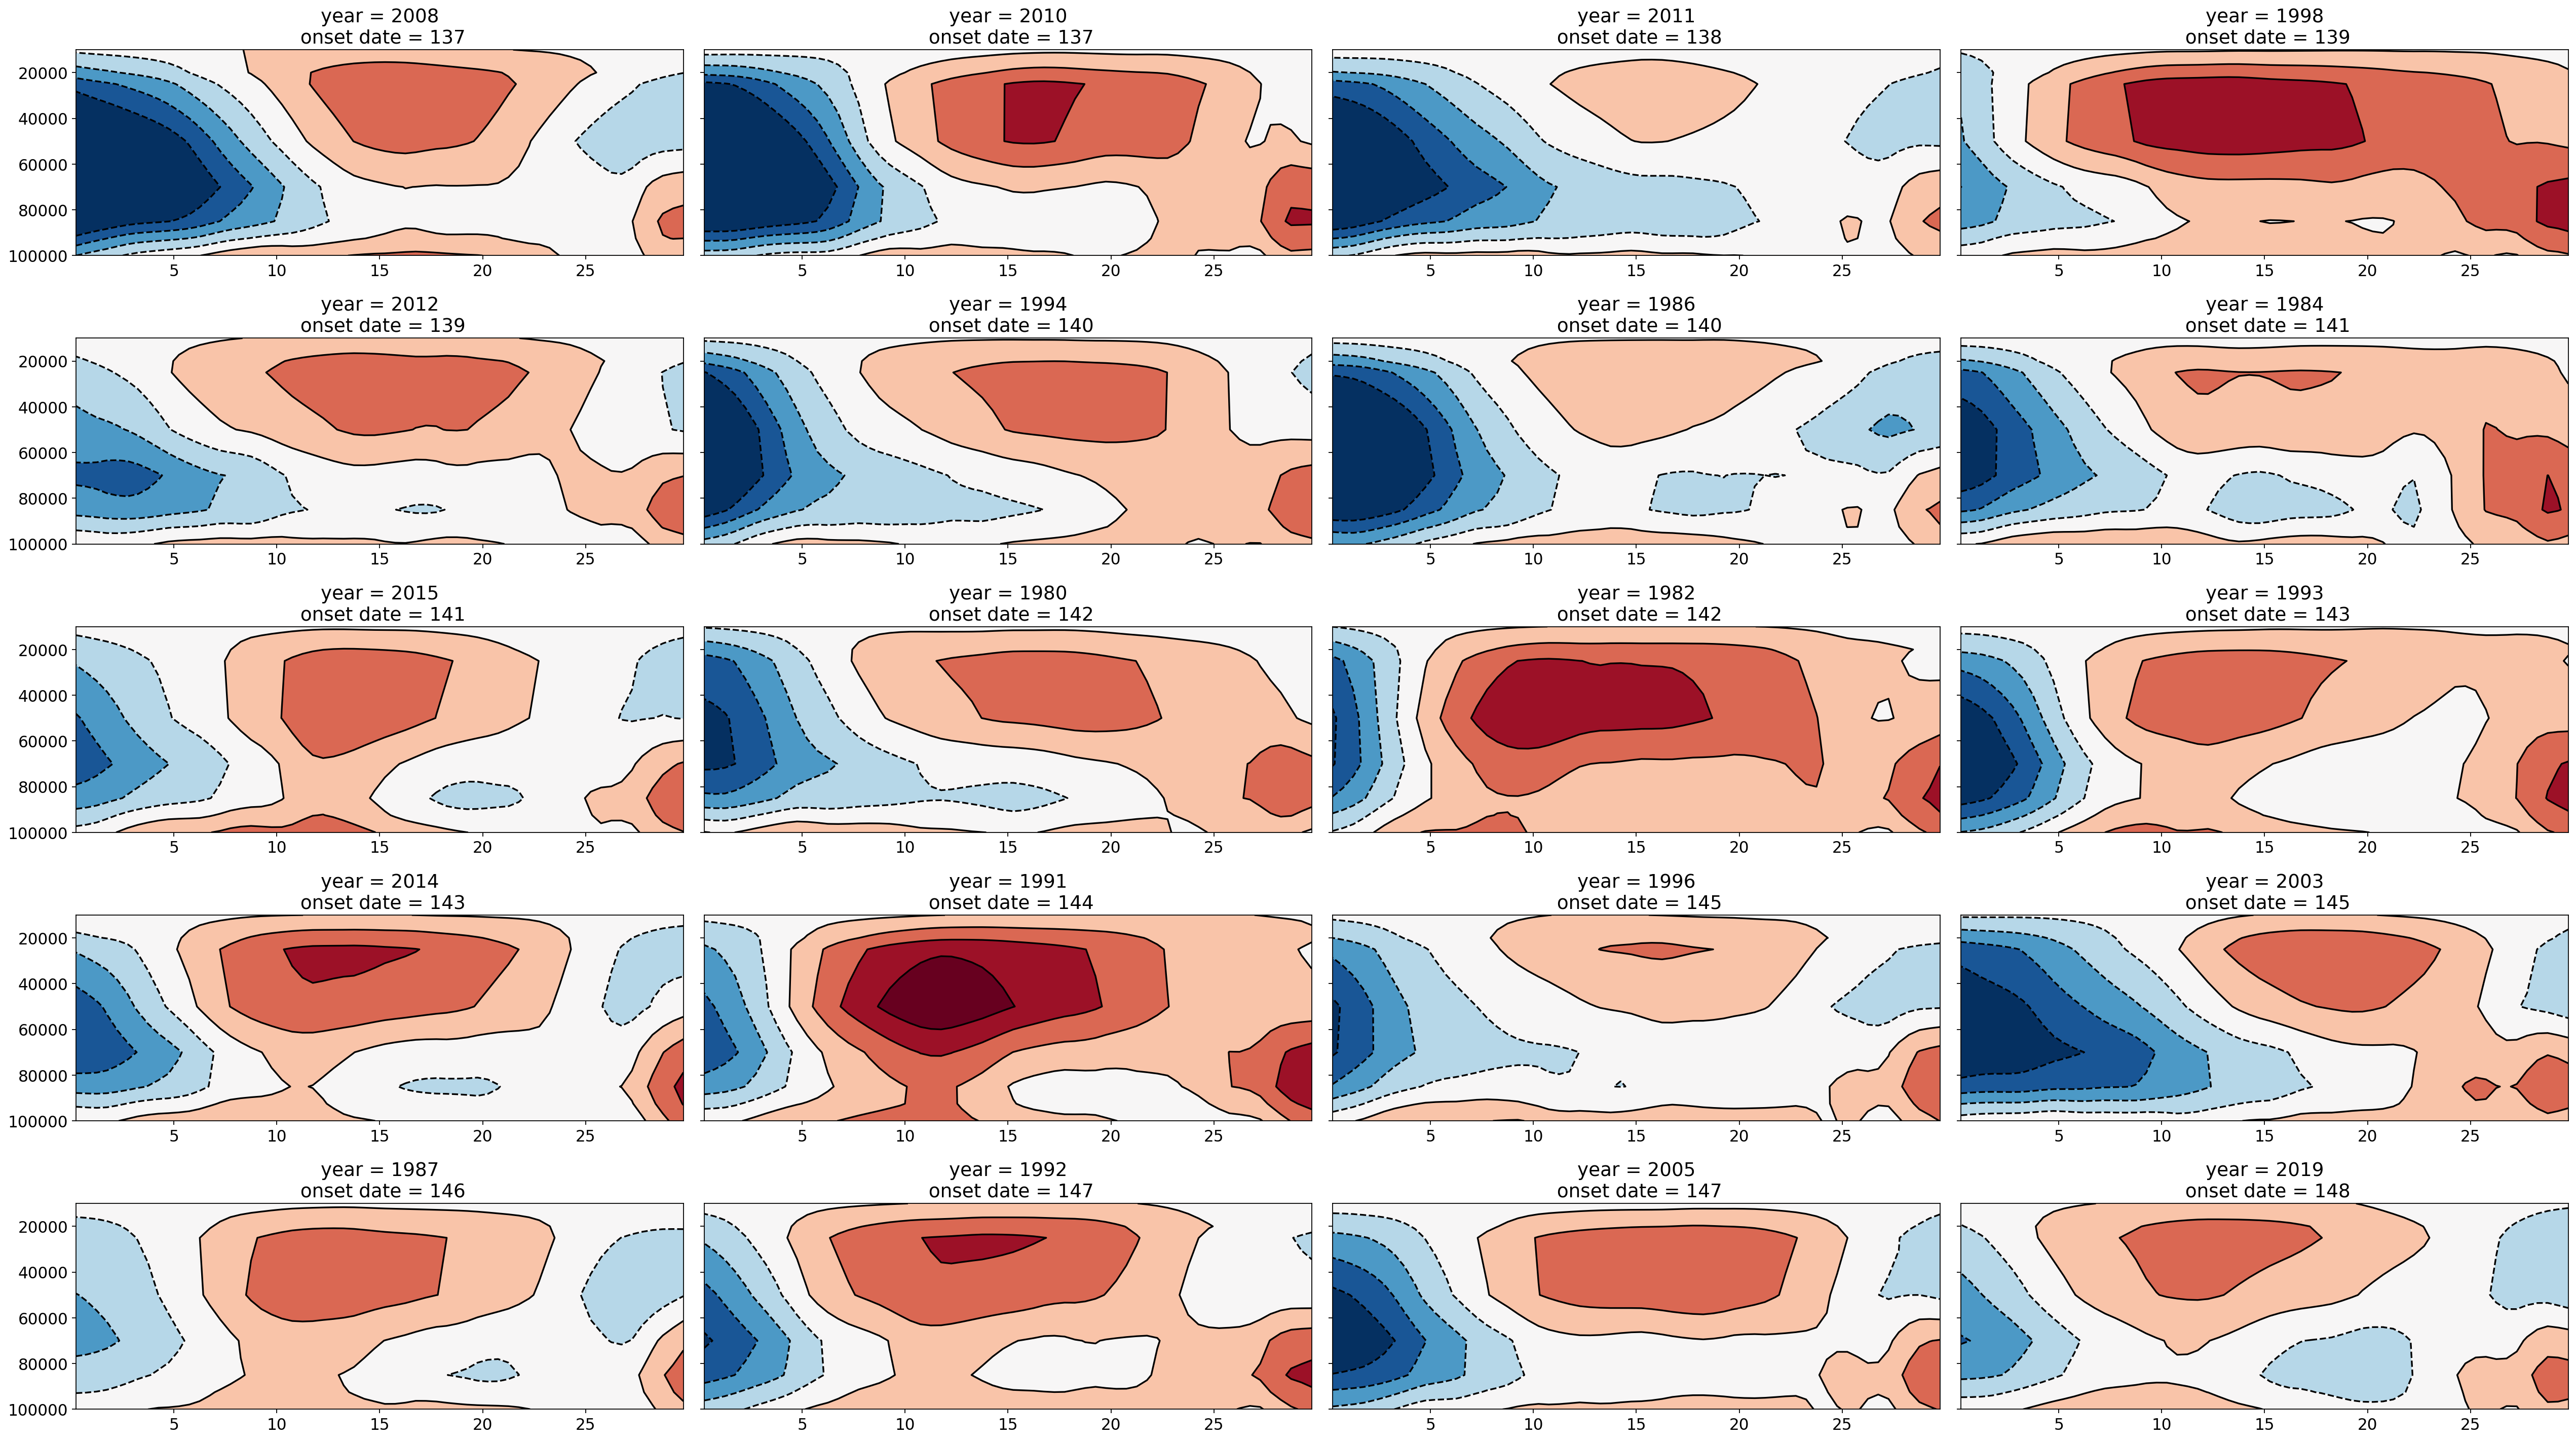

In [11]:
sf, lat, pressure = get_streamfunction(
    "/work/b08209033/DATA/ERA5/Indian_Divergent_UV.nc", global_map=False
)
sf = np.apply_along_axis(
    lambda m: np.convolve(m, np.ones(MOVING_LEN) / MOVING_LEN, mode="same"),
    axis=0,
    arr=sf,
)
sf = sf.reshape(-1, 365, sf.shape[-2], sf.shape[-1])
print(sf.shape)
shuffle = np.argsort(onset_date)
print(onset_date[shuffle])

reference_date = 138
# First 20
fig, axes = plt.subplots(
    nrows=5, ncols=4, figsize=(
        32, 18), dpi=160, sharey=True)
axes[0, 0].invert_yaxis()
for i, ax in enumerate(axes.flatten()):
    tmp_index = shuffle[i]
    tmp_date = onset_date[tmp_index]
    tmp = sf[tmp_index, reference_date]
    ax.contourf(
        lat,
        pressure,
        tmp,
        levels=np.linspace(-2e10, 2e10, 8),
        extend="both",
        cmap="RdBu_r",
    )
    ax.contour(lat, pressure, tmp,
               levels=np.linspace(-2e10, 2e10, 8), colors="k")
    # print()
    ax.set_title(f"year = {tmp_index+1979}\n onset date = {tmp_date}")
plt.tight_layout()
# First 20
fig, axes = plt.subplots(
    nrows=5, ncols=4, figsize=(
        32, 18), dpi=160, sharey=True)
axes[0, 0].invert_yaxis()
for i, ax in enumerate(axes.flatten()):
    tmp_index = shuffle[i + 20]
    tmp_date = onset_date[tmp_index]
    tmp = sf[tmp_index, reference_date]
    ax.contourf(
        lat,
        pressure,
        tmp,
        levels=np.linspace(-2e10, 2e10, 8),
        extend="both",
        cmap="RdBu_r",
    )
    ax.contour(lat, pressure, tmp,
               levels=np.linspace(-2e10, 2e10, 8), colors="k")
    # print()
    ax.set_title(f"year = {tmp_index+1979}\n onset date = {tmp_date}")
plt.tight_layout()